In [58]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.stats.power as smp
import math

- **Продукт:** Сервис по доставке еды. Пользователь может заказать еду через мобильное приложение и заказ доставят в течение 1 часа
- **Тестируемое изменение:** "Спящим" пользователям (тем, кто не делал заказ больше месяца) отправили промокод на скидку 30% на заказ с целью реактивации базы клиентов. Промокод они получили через пуш-уведомление.
- **Цель теста:** Целевая метрика – повторный заказ после применения промокода (базовая конверсия повторного заказа – 0.1 или 10%, мы ожидаем прирост(lift) в повторный заказ на +15%)

In [4]:
df = pd.read_csv('hw3.csv', delimiter=';', index_col=0)
df['p_value'] = pd.to_numeric([i.replace(',','.') for i in df['p_value'].values])
df['lift'] = pd.to_numeric([i.replace(',','.') for i in df['lift'].values])
df.head()

,date,p_value,lift,users
1,2020-02-01,0.40515,0.214387,731
2,2020-02-02,0.31880,0.183620,1461
3,2020-02-03,0.55553,0.082944,2285
4,2020-02-04,0.52978,0.075370,3068
5,2020-02-05,0.93192,0.012945,3909


In [5]:
df.shape

(13, 4)

Расчет p-value – накопительный с учетом предыдущих дней.

**Проанализируйте эксперимент, ориентируясь на p-value: что можно сказать по его поведению? Стоит ли останавливать эксперимент?**

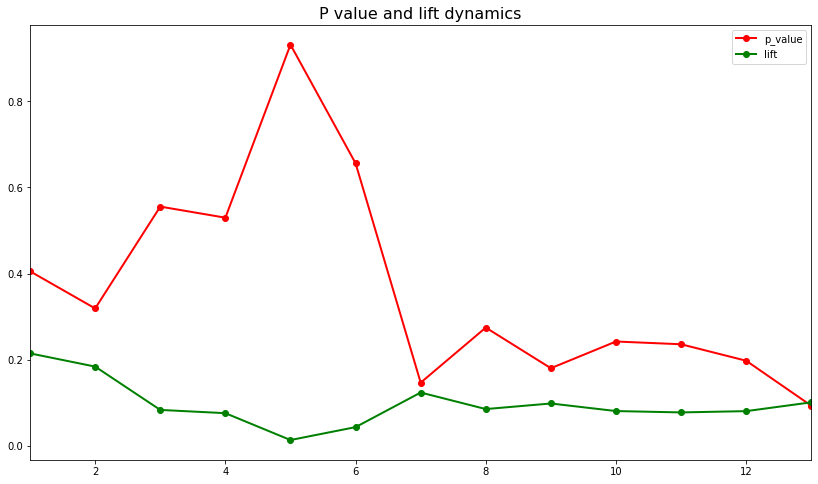

In [15]:
plt.figure(figsize=(14,8))
df['p_value'].plot(linewidth=2.0, marker='o', color='r')
df['lift'].plot(linewidth=2.0, marker='o', color='g')
plt.title('P value and lift dynamics', size=16)
plt.legend(loc='best');

Значение lift на всём промежутке эксперемента можно считать константным, за исключением промежутка со второго по 7 день включительно. P value уверенно растёт до пятого дня и далее не менее уверенно падает, достигая на 13 день минимума (чуть менее 0.2). Вроде бы нет оснований отвергать нулевую гипотезу. Посмотрим как менялось количество пользователей.

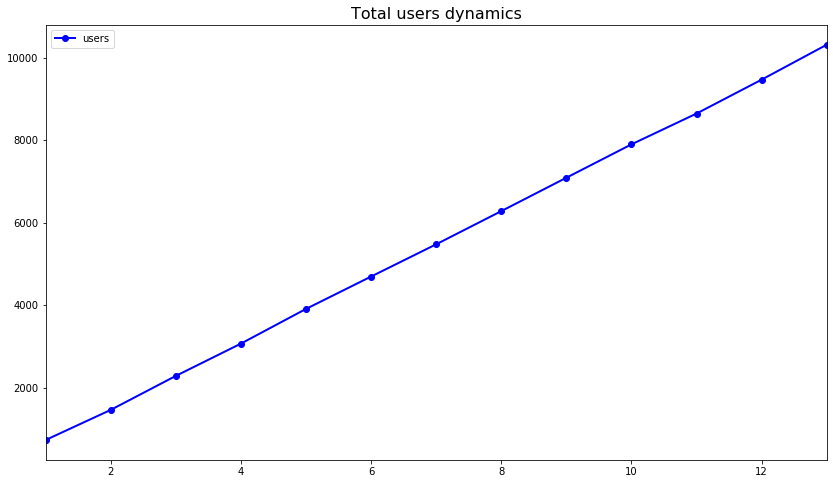

In [16]:
plt.figure(figsize=(14,8))
df['users'].plot(linewidth=2.0, marker='o', color='b')
plt.title('Total users dynamics', size=16)
plt.legend(loc='best');

Каждый день количество пользователей увеличивалось примерно с одним и тем же темпом. Посмотрим, как менялся MDE.

In [29]:
alpha = 0.05
power = 0.9

df['mde'] = list(map(lambda n: smp.zt_ind_solve_power(nobs1 = n, alpha=alpha, power=power), df['users'].values))

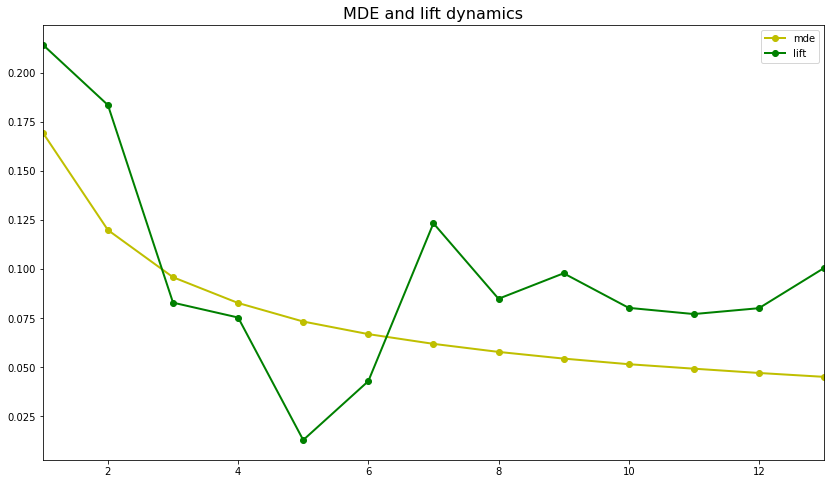

In [31]:
plt.figure(figsize=(14,8))
df['mde'].plot(linewidth=2.0, marker='o', color='y')
df['lift'].plot(linewidth=2.0, marker='o', color='g')
plt.title('MDE and lift dynamics', size=16)
plt.legend(loc='best');

За всё время MDE уменьшился почти в 4 раза и на последний день достиг минимума - чуть более 4 процентов. Если мы продолжим эксперемент в надежде увидеть значимые результаты, то только для эффекта не больше чем в 4 процента, что, в принципе, вписывается в цель теста. Поскольку с 7 недели мы видим, что lift больше ожидаемого эффекта, можно говорить о том, что мы видим реальный прирост в конверсии. С учётом уверенного роста количества пользователей в эксперементе и тенденции на снижение p-value, при прочих равных, я бы продолжил эксперемент.

**Посчитайте время, которое требуется на эксперимент с учетом продукта, тестируемого изменения и цели теста**

In [69]:
base = 0.1

#берём среднее и стандартное отклонение по конверсии за прошлые недели
mean = (np.sum(base + df['lift'].values[7:])) / len(df['lift'].values[7:])
std = np.std(base + df['lift'].values[7:])

power = 0.9
alpha = 0.05
lift = 0.25 - mean #сколько не добрали

In [71]:
# критерий пропорций для кликов и конверсий
n = np.sum(df['users'].values[7:])
#оценённые доли по размерам теста и контроля
p_x = 0.25 
p_y = 0.2875

h = 2*math.asin(np.sqrt(p_x)) - 2*math.asin(np.sqrt(p_y))

In [123]:
# Сколько наблюдений необходимо для заданного эффекта, чтобы
# результаты двухвыборочного теста пропорций были с заданным уровнем значимости 
# и заданной мощностью критерий (1 - вероятность ошибки II-го рода)

n_users = smp.zt_ind_solve_power(effect_size = h, alpha = alpha, power = power, alternative='two-sided')
n_users

2933.6389964848104

Нужно ещё чуть меньше 3000 тысяч пользователей. Посчитаем, за какое время их можно получить.

In [129]:
days = int(n_users)/(df['users'].values[-1] - np.mean(df['users'].values[-2:]))
round(days)

7.0

Нужна ещё примерно неделя для прироста конверсии в 15 процентов.